### Задача

Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

1) Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
2) Постройте модель и провалидируйте её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
3) Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

### Выбор метрики

Активность пользователей - это количество действий, которые они совершают. В случае с нашим приложением такими действиями являются лайки и просмотры. Поэтому в качестве метрики для предсказания возьмем сумму этих действий за день. Отметим, что в нашем приложении также есть мессенджер, но до сих пор количество сообщений в день [практически не меняется и остается несопоставимым с количеством лайков и просмотров постов в ленте](https://github.com/Nik-Smirnov/SimDA_KarpovCourses/blob/05b9be0a13e9af41b927bdcea1d77da80242a5ea/4.MetricsPrediction/Actions.jpg "График активности"). 

Известно, что в период с 14 по 20 июля проходил флэшмоб, когда наблюдались аномально высокая активность пользователей. Поэтому можем попробовать в качестве регрессора модели использовать переменную, у которой этот период, а также следующий за ним день (когда сохранялась инерция от события), будет прокодирован как 1. Так мы снизим влияние флэшмоба на прогноз. 
В качестве второго регрессора возьмем DAU.

In [1]:
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mae, mse, smape, wmape

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

### Достаем данные и смотрим на них

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'******',
                      'user':'student', 
                      'password':'******'
                     }

query = '''
    select 
        toDate(time) as date
        ,count(user_id) as actions
        ,count(distinct user_id) as DAU
        ,if(toDate(time) >= '2023-07-14' and toDate(time) <= '2023-07-21', 1, 0) as anomaly_rise
    from {db}.feed_actions
    where toDate(time) < today()
    group by toDate(time)
    order by date
'''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,date,actions,DAU,anomaly_rise
0,2023-06-03,9163,878,0
1,2023-06-04,75586,2238,0
2,2023-06-05,126484,3105,0
3,2023-06-06,142796,3721,0
4,2023-06-07,208958,4617,0


In [3]:
df[df['anomaly_rise'] == 1]

,date,actions,DAU,anomaly_rise
41,2023-07-14,814364,14829,1
42,2023-07-15,1082642,15526,1
43,2023-07-16,1236421,15867,1
44,2023-07-17,1415092,16341,1
45,2023-07-18,1320575,16469,1
46,2023-07-19,1315324,16632,1
47,2023-07-20,1481844,16705,1
48,2023-07-21,1334298,16195,1


<Axes: xlabel='date', ylabel='actions'>

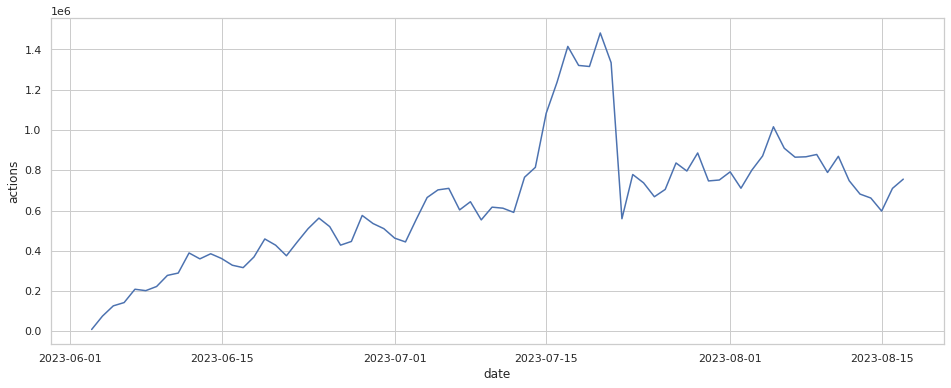

In [49]:
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")
sns.lineplot(x="date", y="actions", data=df)

<Axes: xlabel='date', ylabel='DAU'>

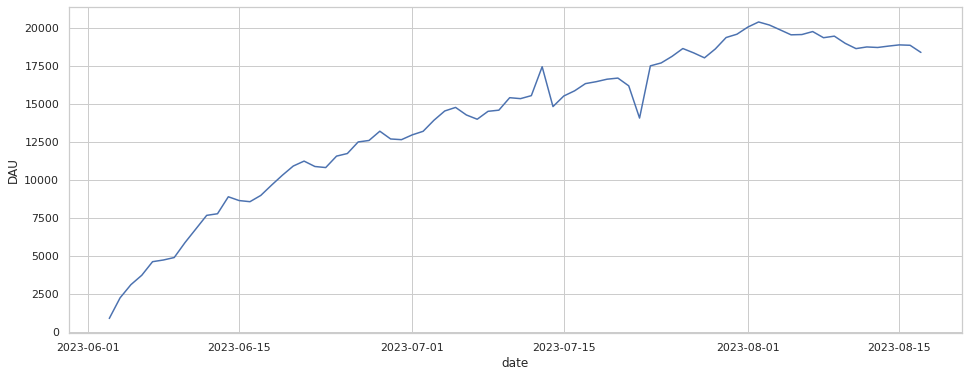

In [50]:
sns.lineplot(x="date", y="DAU", data=df)

Отметим бинарными переменными пик (13.07.2023) и падение (22.07.2023) DAU для использования их в качестве регрессоров при прогнозировании DAU.

In [6]:
df["rise_DAU"] = np.where(df.date == "2023-07-13", 1, 0)
df["fall_DAU"] = np.where(df.date == "2023-07-22", 1, 0)
df.head()

,date,actions,DAU,anomaly_rise,rise_DAU,fall_DAU
0,2023-06-03,9163,878,0,0,0
1,2023-06-04,75586,2238,0,0,0
2,2023-06-05,126484,3105,0,0,0
3,2023-06-06,142796,3721,0,0,0
4,2023-06-07,208958,4617,0,0,0


Стандартизируем метрики:

In [7]:
act_mean = df.actions.mean()
act_sd = df.actions.std()

dau_mean = df.DAU.mean()
dau_sd = df.DAU.std()

df["DAU_stand"] = (df.DAU - dau_mean) / dau_sd
df["act_stand"] = (df.actions - act_mean) / act_sd

df.head()

,date,actions,DAU,anomaly_rise,rise_DAU,fall_DAU,DAU_stand,act_stand
0,2023-06-03,9163,878,0,0,0,-2.602148,-2.053847
1,2023-06-04,75586,2238,0,0,0,-2.332901,-1.838174
2,2023-06-05,126484,3105,0,0,0,-2.161255,-1.672909
3,2023-06-06,142796,3721,0,0,0,-2.039302,-1.619945
4,2023-06-07,208958,4617,0,0,0,-1.861916,-1.405119


### Построение моделей

Построим следующие модели:

1. Обычная модель с линейным трендом
2. Обычная модель с логлинейным трендом
3. Линейный тренд + DAU как регрессор
4. Логлинейный тренд + DAU как регрессор
5. Линейный тренд + DAU + аномалия
6. Логлинейный тренд + DAU + аномалия

In [8]:
simple_lin = DLT(response_col="act_stand", 
                 date_col="date", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

simple_loglin = DLT(response_col="act_stand", 
                 date_col="date", 
                 estimator="stan-mcmc", 
                 global_trend_option="loglinear",
                 num_warmup=10000,
                 num_sample=10000)

dau_lin = DLT(response_col="act_stand", 
            date_col="date", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand"], regressor_sign=["+"], 
            num_warmup=10000,
            num_sample=10000)

dau_loglin = DLT(response_col="act_stand", 
               date_col="date", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand"], regressor_sign=["+"], 
               num_warmup=10000,
               num_sample=10000)

anom_lin = DLT(response_col="act_stand", 
            date_col="date", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand", "anomaly_rise"], regressor_sign=["+", "+"], 
            num_warmup=10000,
            num_sample=10000)

anom_loglin = DLT(response_col="act_stand", 
               date_col="date", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand", "anomaly_rise"], regressor_sign=["+", "+"], 
               num_warmup=10000,
               num_sample=10000)

In [9]:
#положим в список

model_list = [simple_lin, simple_loglin, dau_lin, dau_loglin, anom_lin, anom_loglin]

In [ ]:
#обучаем

for model in model_list:
    
    model.fit(df)

In [11]:
# Датафрейм на месяц вперед для первых двух моделей:

futur = model_list[0].make_future_df(periods=30)

In [12]:
# Строим предсказания
pred_1 = model_list[0].predict(futur)
pred_2 = model_list[1].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

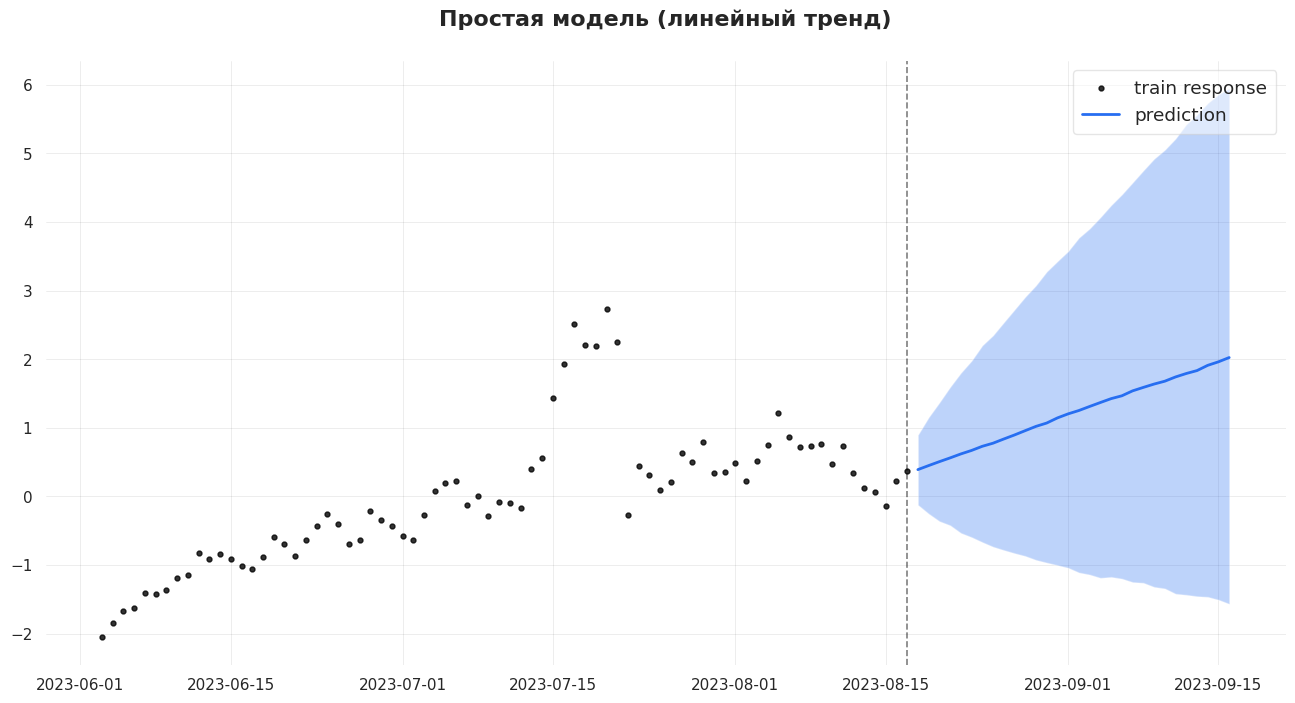

In [13]:
_ = plot_predicted_data(df, pred_1, "date", 'act_stand', title='Простая модель (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

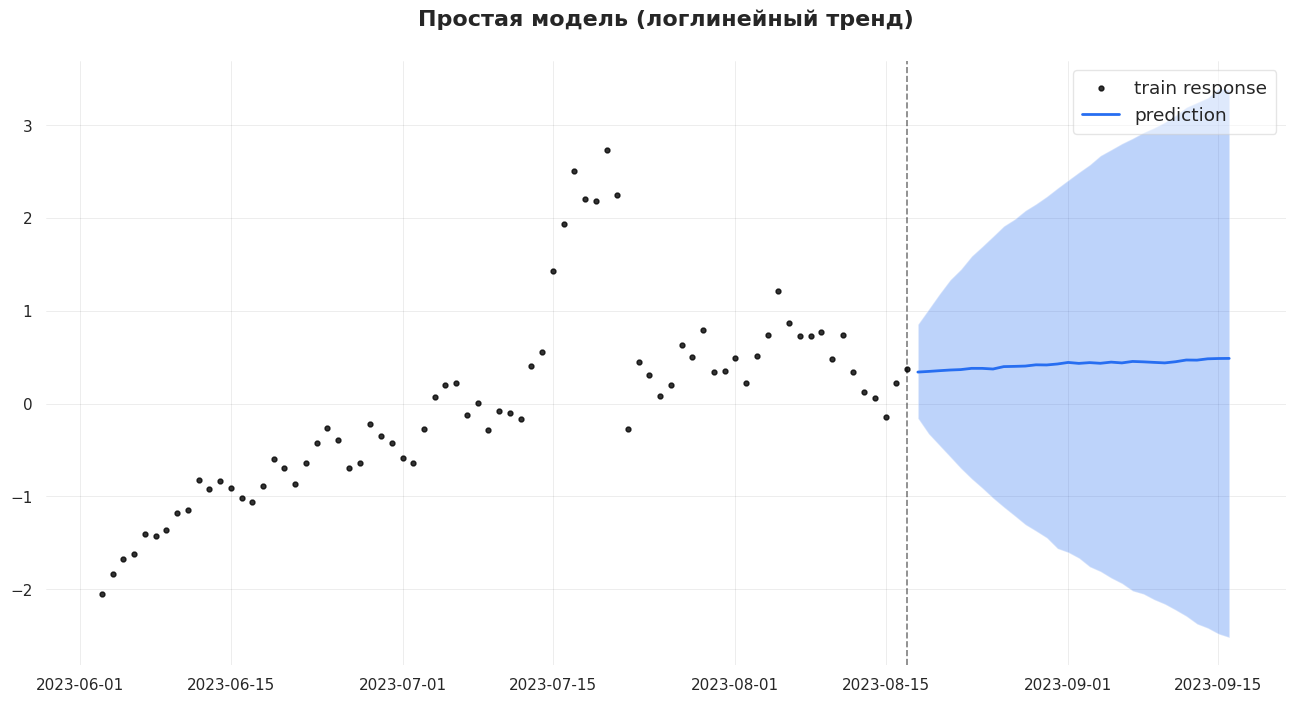

In [14]:
_ = plot_predicted_data(df, pred_2, "date", 'act_stand', title='Простая модель (логлинейный тренд)')

Для всех остальных моделей необходим прогноз DAU

In [ ]:
dau_model = DLT(response_col="DAU_stand", 
                 date_col="date", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 regressor_col=["rise_DAU", "fall_DAU"], regressor_sign=["+", "-"],
                 num_warmup=10000,
                 num_sample=10000)

dau_model.fit(df)

In [16]:
#Добавляем регрессоры в будущее
futur["rise_DAU"] = [0 for i in range(len(futur))]
futur["fall_DAU"] = [0 for i in range(len(futur))]
futur.head()

,date,rise_DAU,fall_DAU
0,2023-08-18,0,0
1,2023-08-19,0,0
2,2023-08-20,0,0
3,2023-08-21,0,0
4,2023-08-22,0,0


In [17]:
#Предсказываем
dau_pred = dau_model.predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

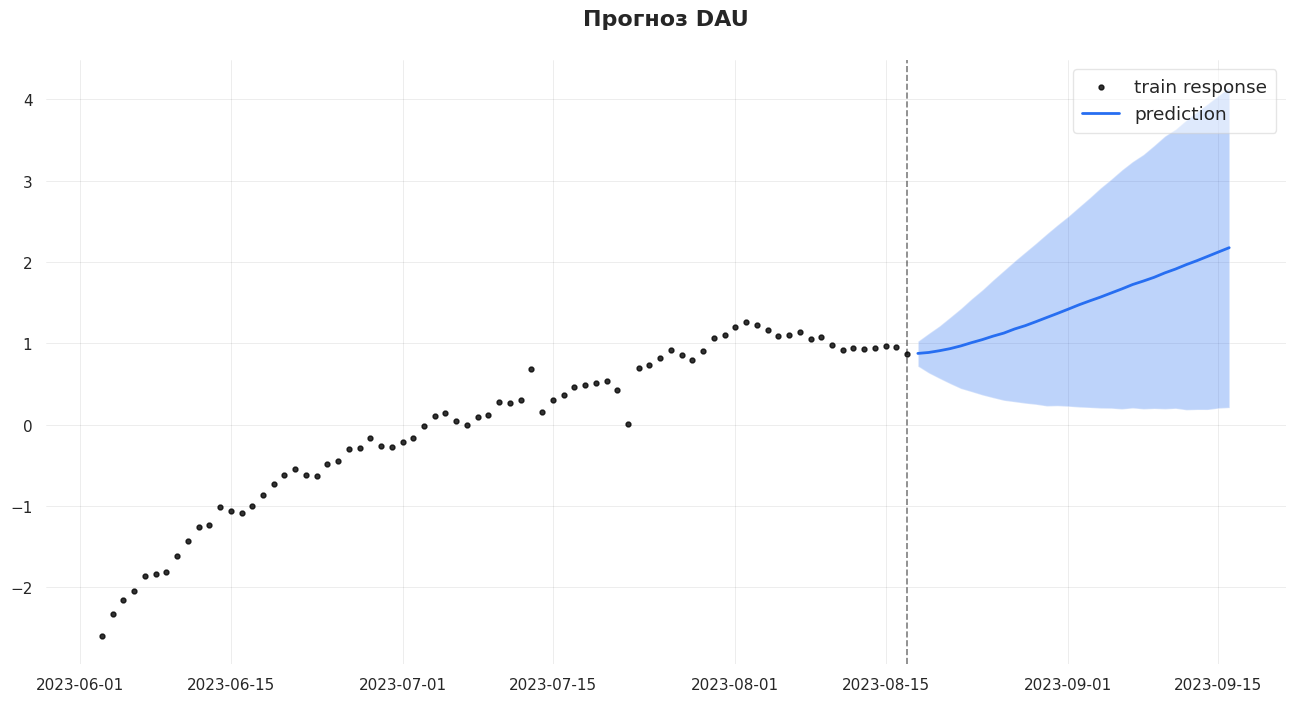

In [18]:
_ = plot_predicted_data(df, dau_pred, "date", 'DAU_stand', title='Прогноз DAU')

Добавим прогноз в наш будущий df:

In [19]:
dau_pred.head()

,date,prediction_5,prediction,prediction_95
0,2023-08-18,0.718455,0.875749,1.026446
1,2023-08-19,0.635862,0.887055,1.121871
2,2023-08-20,0.568687,0.908444,1.213858
3,2023-08-21,0.504205,0.934253,1.320851
4,2023-08-22,0.444269,0.967759,1.429445


In [20]:
futur["DAU_stand"] = dau_pred.prediction
futur.head()

,date,rise_DAU,fall_DAU,DAU_stand
0,2023-08-18,0,0,0.875749
1,2023-08-19,0,0,0.887055
2,2023-08-20,0,0,0.908444
3,2023-08-21,0,0,0.934253
4,2023-08-22,0,0,0.967759


In [21]:
# Посмотрим на предсказанные значения в 
dau_pred_orig = dau_pred.copy()
dau_pred_orig[["prediction_5", "prediction", "prediction_95"]] = dau_pred_orig[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * dau_sd) + dau_mean)
dau_pred_orig.tail()

,date,prediction_5,prediction,prediction_95
25,2023-09-12,14942.309672,23957.064484,32938.818283
26,2023-09-13,14961.898073,24204.729383,33455.669421
27,2023-09-14,14961.252193,24471.946388,33949.384181
28,2023-09-15,15048.815885,24742.176782,34467.072957
29,2023-09-16,15083.568814,25008.655667,34969.707431


Строим предсказания для 3 и 4 моделей

In [22]:
pred_3 = model_list[2].predict(futur)
pred_4 = model_list[3].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

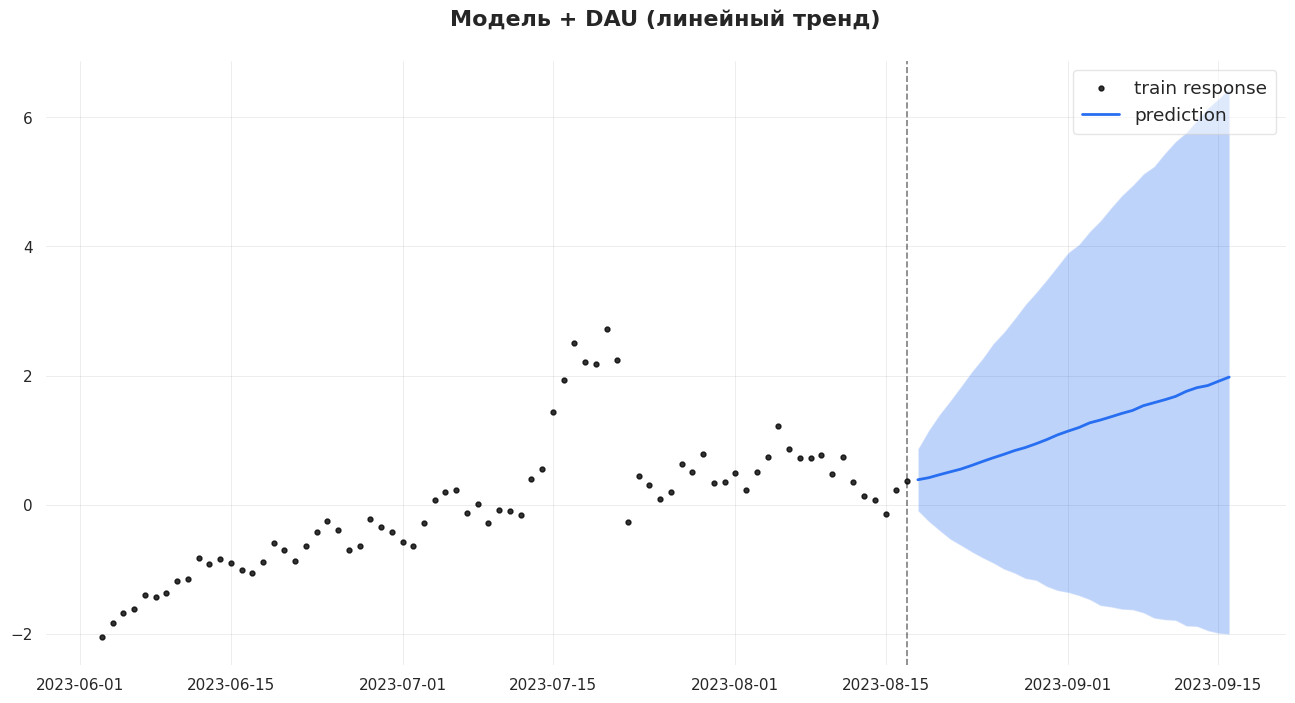

In [23]:
_ = plot_predicted_data(df, pred_3, "date", 'act_stand', title='Модель + DAU (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

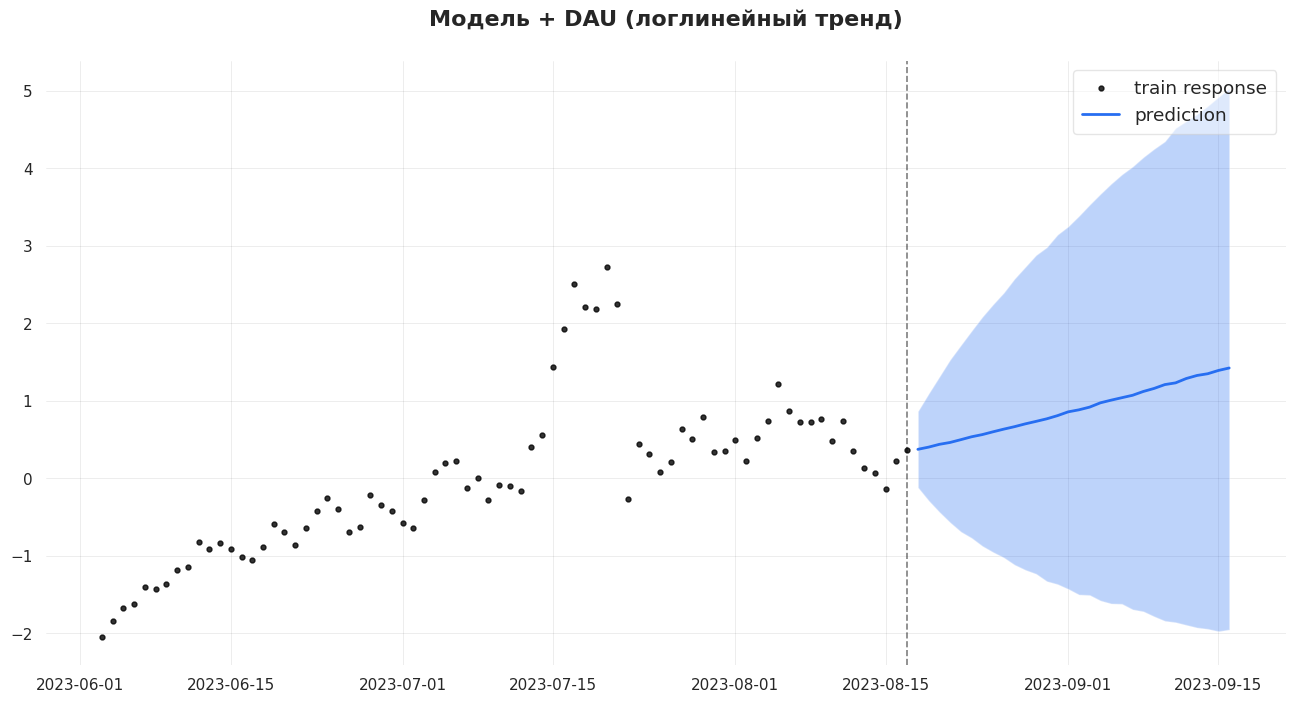

In [24]:
_ = plot_predicted_data(df, pred_4, "date", 'act_stand', title='Модель + DAU (логлинейный тренд)')

Для последних двух моделей добавляем бинарную переменную

In [25]:
futur["anomaly_rise"] = 0 
futur.head()

,date,rise_DAU,fall_DAU,DAU_stand,anomaly_rise
0,2023-08-18,0,0,0.875749,0
1,2023-08-19,0,0,0.887055,0
2,2023-08-20,0,0,0.908444,0
3,2023-08-21,0,0,0.934253,0
4,2023-08-22,0,0,0.967759,0


In [26]:
pred_5 = model_list[4].predict(futur)
pred_6 = model_list[5].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

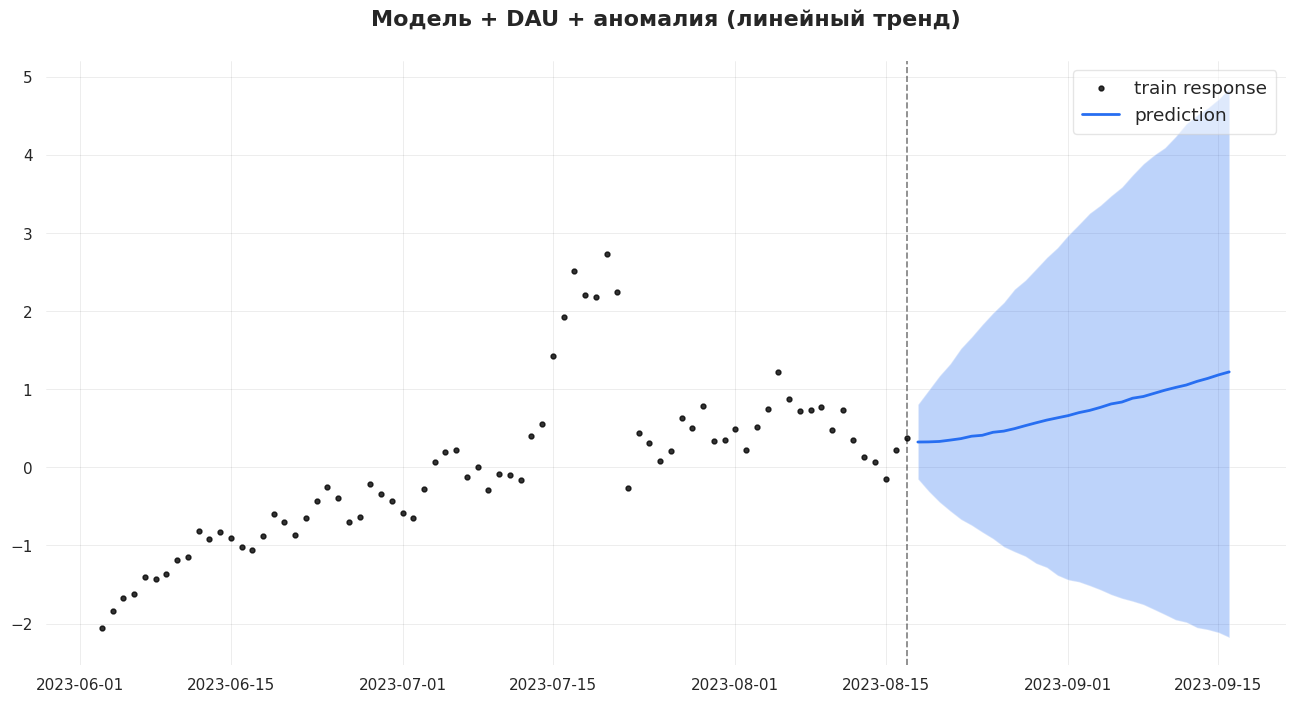

In [27]:
_ = plot_predicted_data(df, pred_5, "date", 'act_stand', title='Модель + DAU + аномалия (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

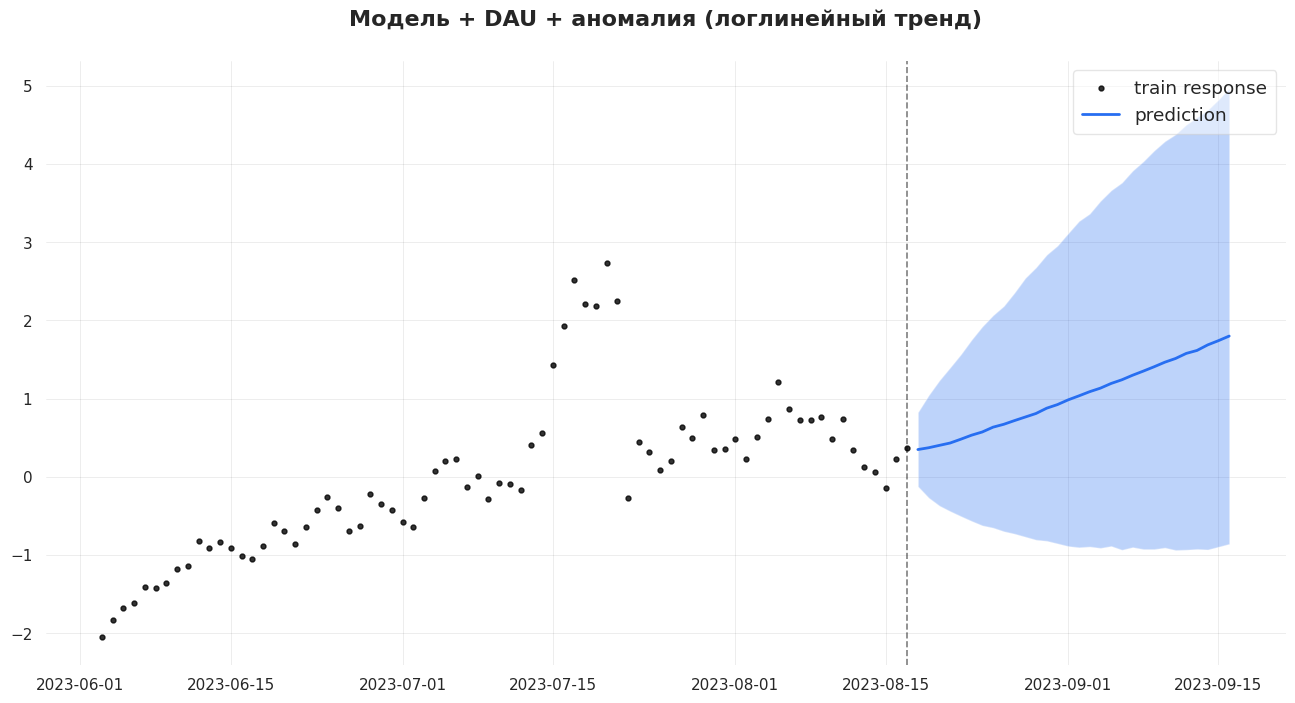

In [28]:
_ = plot_predicted_data(df, pred_6, "date", 'act_stand', title='Модель + DAU + аномалия (логлинейный тренд)')

### Оценка качества моделей

#### Бэктестинг

Важно: мы хотим предсказывать на месяц вперед (30 дней). В связи с эти длина прогноза в бэктестинга должна быть также 30 дней. Количество же дней для обучения модели не должно быть меньше, чем горизонт прогнозирования. В связи с тем, что у нас есть данные только за 2,5 месяца, мы можем адекватный бэктестинг осуществить только 1 раз.

Поэтому возьмем для бэктестинга горизонт прогнозирования, равный 1 неделе, делая допущение о том, что качество прогнозов наших моделей на неделю не отличается от прогнозов на месяц. 

In [ ]:
#сделаем список для бэктестеров
#начнём со скользящего

test_list_rolling = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

In [ ]:
# теперь для расширяющегося
test_list_exp = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
    backtester.fit_predict()
    
    test_list_exp.append(backtester)

Посмотрим, что получилось:

In [31]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.882169,False
1,wmape,1.002691,False
1,mape,3.214231,False
1,mse,1.176112,False
1,mae,0.721772,False


In [32]:
for metric in roll_df.metric_name.unique():
    
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 6
Самая лучшая модель по метрике mape - 6
Самая лучшая модель по метрике mse - 6
Самая лучшая модель по метрике mae - 6
Самая лучшая модель по метрике rmsse - 6


In [33]:
roll_df[roll_df['metric_name'] == 'smape']

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.882169,False
2,smape,0.733460,False
3,smape,0.854479,False
4,smape,0.743406,False
5,smape,0.905764,False
6,smape,0.740941,False


In [34]:
exp_df = []

for number, tester in enumerate(test_list_exp):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    exp_df.append(inter_df)
    
exp_df = pd.concat(exp_df)
exp_df = exp_df.set_index("model_number")

exp_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.895755,False
1,wmape,0.826014,False
1,mape,1.800962,False
1,mse,0.837769,False
1,mae,0.594594,False


In [35]:
for metric in exp_df.metric_name.unique():
    
    winning_model = exp_df.loc[exp_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 6
Самая лучшая модель по метрике wmape - 6
Самая лучшая модель по метрике mape - 5
Самая лучшая модель по метрике mse - 6
Самая лучшая модель по метрике mae - 6
Самая лучшая модель по метрике rmsse - 6


In [36]:
exp_df[roll_df['metric_name'] == 'mape']

,metric_name,metric_values,is_training_metric
model_number,,,
1,mape,1.800962,False
2,mape,1.720578,False
3,mape,1.725404,False
4,mape,1.676244,False
5,mape,1.409304,False
6,mape,1.431685,False


Таким образом, почти по всем метрикам качества моделей лучшей оказалась шестая модель: с логлинейным трендом и двумя регрессорами. 
В случаях с метриками, которые выявили других победителей, эта модель была на втором месте.

#### Информационные критерии

In [ ]:
for model in model_list:
    
    model.fit_wbic(df)

In [38]:
for number, model in enumerate(model_list):
    
    print(f"Модель №{number+1}, WBIC = {model.get_wbic()}")

Модель №1, WBIC = 65.74848483338607
Модель №2, WBIC = 63.36282637332371
Модель №3, WBIC = 60.56784685529027
Модель №4, WBIC = 58.30607152465032
Модель №5, WBIC = 47.0667110024998
Модель №6, WBIC = 43.732760883916995


По критерию (W)BIC лучшей также стала модель №6.

#### Разложим предсказания этой модели на составляющие.

In [39]:
comps = model_list[5].predict(futur, decompose=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

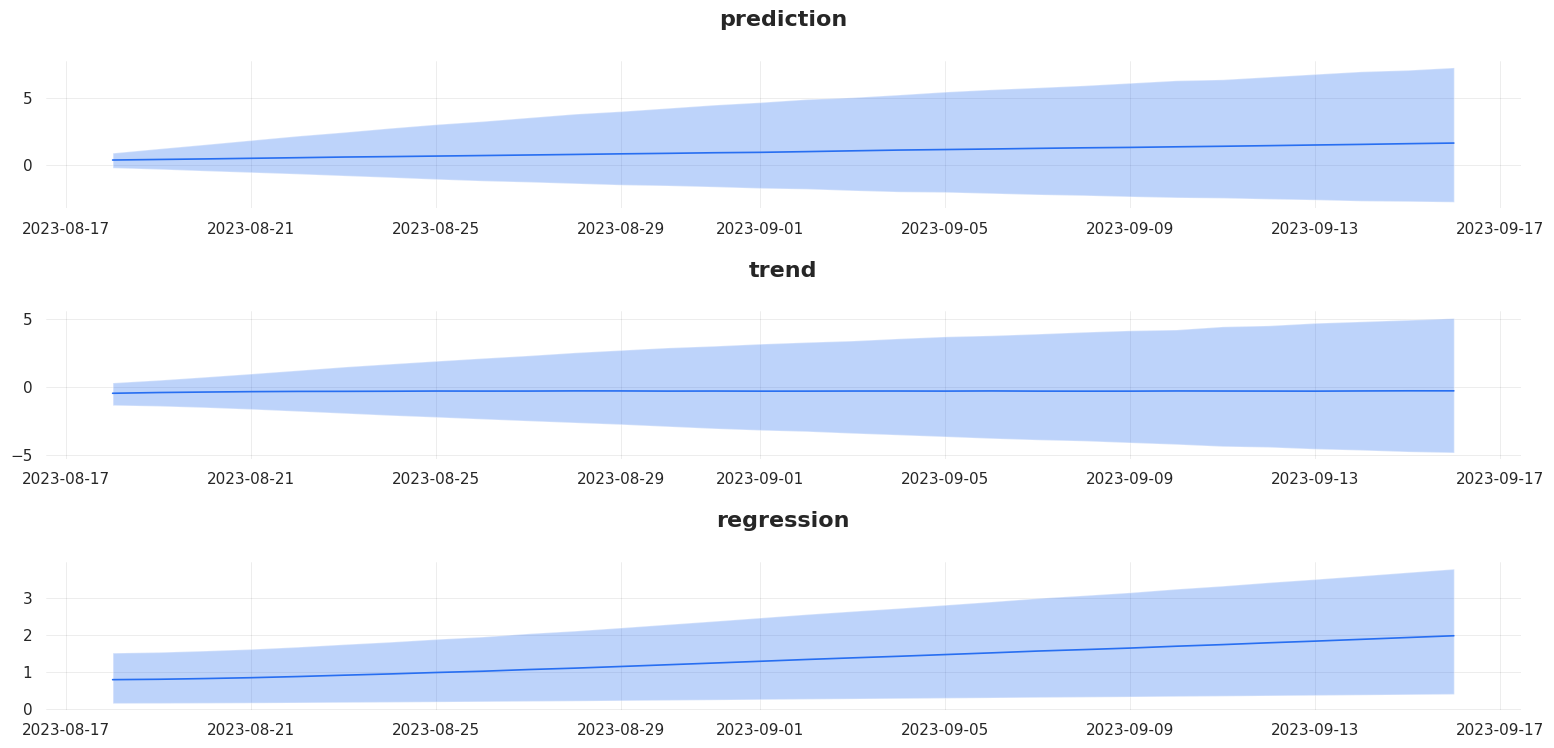

In [40]:
_ = plot_predicted_components(comps, "date", plot_components=['prediction', 'trend', 'regression'])

In [41]:
comps.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-08-18,-0.210405,0.358312,0.899926,-1.319095,-0.448560,0.342122,0.0,0.0,0.0,0.165931,0.796619,1.522453
1,2023-08-19,-0.314308,0.400059,1.220648,-1.381937,-0.393749,0.539927,0.0,0.0,0.0,0.168073,0.806904,1.542108
2,2023-08-20,-0.437791,0.441030,1.532262,-1.484931,-0.358289,0.770049,0.0,0.0,0.0,0.172126,0.826360,1.579291
3,2023-08-21,-0.553429,0.487381,1.852829,-1.613633,-0.328303,1.009064,0.0,0.0,0.0,0.177016,0.849838,1.624160
4,2023-08-22,-0.668665,0.532762,2.171796,-1.760806,-0.310530,1.257695,0.0,0.0,0.0,0.183365,0.880316,1.682408


In [42]:
comps.tail()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
25,2023-09-12,-2.537329,1.431102,6.577593,-4.413333,-0.286511,4.561797,0.0,0.0,0.0,0.372685,1.789224,3.419461
26,2023-09-13,-2.598153,1.480144,6.779547,-4.546783,-0.290910,4.746954,0.0,0.0,0.0,0.381975,1.833825,3.504700
27,2023-09-14,-2.681069,1.524633,6.974695,-4.635451,-0.277777,4.860570,0.0,0.0,0.0,0.391999,1.881948,3.596669
28,2023-09-15,-2.713483,1.577966,7.081555,-4.747992,-0.267642,4.978030,0.0,0.0,0.0,0.402136,1.930613,3.689675
29,2023-09-16,-2.754899,1.624196,7.266001,-4.814938,-0.269790,5.100319,0.0,0.0,0.0,0.412131,1.978603,3.781390


Модель №6 предсказывает, что количество действий пользователей будет со временем увеличиваться. При этом в основном это увеличение обусловлено значениями регрессоров. Точнее - предсказанными значениями DAU. Вполне возможно, что мы переоценили рост активной аудитории, что впоследствии повлияло на прогноз количества лайков и просмотров, завысив его. 

При этом важно заметить, что в рамках нашей задачи, для нас в некоторой мере менее опасно несколько переоценить рост пользовательской активности.

#### Проверим, сошелся ли MCMC

In [43]:
ps = model_list[5].get_posterior_samples(relabel=True, permute=False)
ps.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 'gt_sum', 'gb', 'gl', 'loglk', 'DAU_stand', 'anomaly_rise'])

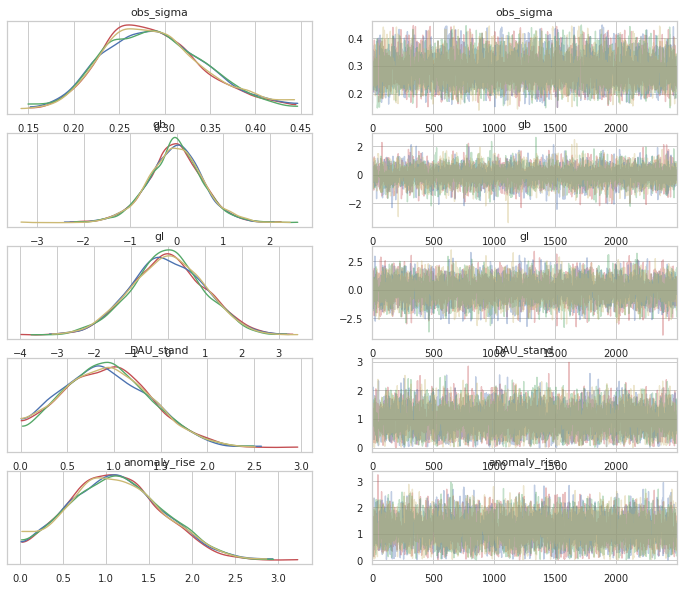

In [44]:
az.plot_trace(
    ps,
    var_names=['obs_sigma', 'gb', 'gl', 'DAU_stand', 'anomaly_rise'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
);

Все рассматриваемые показатели сходятся примерно на одном уровне. Регрессоры, как и должно быть, выше нуля. Алгоритм MCMC отработал правильно.

### Переведем предсказания в оригинальные единицы измерения

In [45]:
pred_6[["prediction_5", "prediction", "prediction_95"]] = pred_6[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * act_sd) + act_mean)

In [46]:
pred_6

,date,prediction_5,prediction,prediction_95
0,2023-08-18,603635.236828,7.489601e+05,8.959332e+05
1,2023-08-19,559107.561360,7.560324e+05,9.629411e+05
2,2023-08-20,527673.565358,7.653739e+05,1.021555e+06
3,2023-08-21,506063.722921,7.746376e+05,1.072367e+06
4,2023-08-22,486328.784820,7.896726e+05,1.124100e+06
5,2023-08-23,467389.545383,8.055232e+05,1.181769e+06
6,2023-08-24,449947.223060,8.181516e+05,1.233961e+06
7,2023-08-25,441028.604333,8.370784e+05,1.278115e+06
8,2023-08-26,426933.362373,8.484108e+05,1.314542e+06
9,2023-08-27,417289.448878,8.630314e+05,1.367325e+06


In [47]:
df.tail()

,date,actions,DAU,anomaly_rise,rise_DAU,fall_DAU,DAU_stand,act_stand
71,2023-08-13,681664,18720,0,0,0,0.930137,0.129742
72,2023-08-14,662016,18811,0,0,0,0.948153,0.065946
73,2023-08-15,597196,18891,0,0,0,0.963991,-0.144522
74,2023-08-16,709844,18865,0,0,0,0.958844,0.221242
75,2023-08-17,755837,18394,0,0,0,0.865597,0.370580


In [48]:
pred_6.iloc[29]

date             2023-09-16 00:00:00
prediction_5           377329.471083
prediction            1196003.866481
prediction_95         2172114.332738
Name: 29, dtype: object

Таким образом, мы можем ожидать, что через 30 дней количество лайков и просмотров в новостной ленте нашего приложения увеличится с 750 тыс. до примерно 1,2 млн. Однако этот прогноз можем считать адекватным только при условии дальнейшего роста активной аудитории приложения.